# 05b_pct_built_by_block option B
### (Cuts blocks and buildings by hex and calculates pct_built directly)
### [Does not create built_pct by block gdf]

The objective is to find the areas of a city where blocks have a smaller and a greater built footprint in order to compare that data with the temperature data [Merida]

* __Input:__ Hexs res 8 (Creates aoi), Google open buildings, blocks, hex specified res (Output)
* __Output: Hhexs with mean pct built by block__

## __Import libraries__

In [1]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Transform google open buildings's geometry
from shapely import wkt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## __Notebook config__

In [3]:
city = 'Merida'
projected_crs = 'EPSG:32616' #Mérida
output_res = 9
# Directory where output files are saved
save_output = False
map_output_dir = str(main_folder_path) + f"data/processed/temperature_2025_check/built_area/"

## __Create area of interest__

In [4]:
# Load city's hex res 8
hex_schema = 'hexgrid'
hex_table = 'hexgrid_8_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Ensure projected_crs
if hex_gdf.crs != projected_crs:
    hex_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed hex_gdf crs to {projected_crs}.")

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

Changed hex_gdf crs to EPSG:32616.
EPSG:32616
(718, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,8845098099fffff,"POLYGON ((244697.664 2304088.133, 245166.509 2...",31002,Acanceh,Merida,urban
1,88450980d9fffff,"POLYGON ((244178.748 2301597.213, 244647.595 2...",31002,Acanceh,Merida,urban


EPSG:32616
(1, 6)


<Axes: >

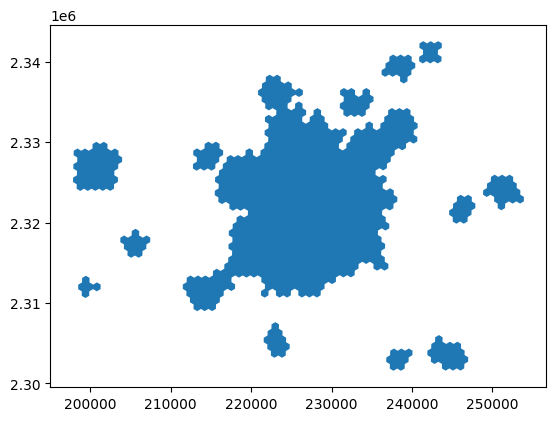

In [5]:
aoi = hex_gdf.dissolve()

# Show
print(aoi.crs)
print(aoi.shape)
aoi.plot()

## __Find all blocks within reach of area of interest__

#### Load city's blocks

In [6]:
# Create a list from a list with all unique cvegeo_mun ('CVE_ENT'+'CVE_MUN') of current city
cvegeo_mun_lst = list(hex_gdf.CVEGEO.unique())

# Load city municipality's blocks
blocks_schema = 'marco'
blocks_table = 'mza_2020'

blocks_gdf = gpd.GeoDataFrame()
for cvegeo_mun in cvegeo_mun_lst:
    
    blocks_query = f"SELECT * FROM {blocks_schema}.{blocks_table} WHERE \"CVEGEO\" LIKE \'{cvegeo_mun}%\'"
    mun_blocks_gdf = aup.gdf_from_query(blocks_query, geometry_col='geometry')
    blocks_gdf = pd.concat([blocks_gdf,mun_blocks_gdf])

# Ensure projected_crs
if blocks_gdf.crs != projected_crs:
    blocks_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed blocks_gdf crs to {projected_crs}.")
    
# Show
print(blocks_gdf.crs)
print(blocks_gdf.shape)
blocks_gdf.head(2)

Changed blocks_gdf crs to EPSG:32616.
EPSG:32616
(23145, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,3100200110053013,31,002,0011,0053,013,Rural,Típica,"POLYGON ((246019.845 2311683.264, 246186.92 23..."
1,3100200010087033,31,002,0001,0087,033,Urbana,Típica,"POLYGON ((245896.657 2302982.457, 245775.311 2..."


#### Blocks that touch area of interest

In [7]:
# Keep blocks that touch the area of interest
aoi_union = aoi.union_all()  # Create shapely object
blocks_aoi_gdf = blocks_gdf[blocks_gdf.intersects(aoi_union)].copy()

# Show
print(blocks_aoi_gdf.crs)
print(blocks_aoi_gdf.shape)
blocks_aoi_gdf.head(2)

EPSG:32616
(21277, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
1,3100200010087033,31,002,0001,0087,033,Urbana,Típica,"POLYGON ((245896.657 2302982.457, 245775.311 2..."
2,3100200010091010,31,002,0001,0091,010,Urbana,Típica,"POLYGON ((245377.191 2302852.46, 245367.472 23..."


#### Show

<Axes: >

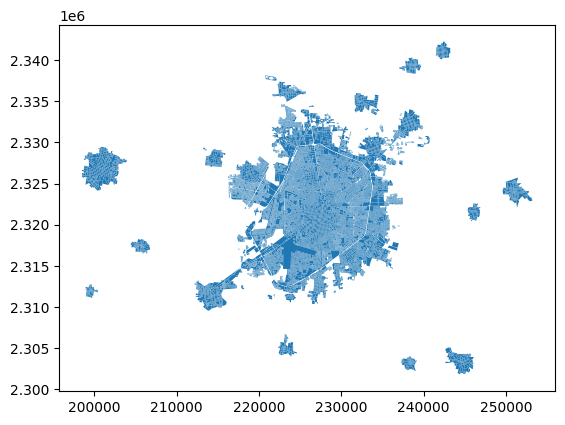

In [8]:
blocks_aoi_gdf.plot()

## __Load google buildings__

In [9]:
# Load csv
buildings_df = pd.read_csv(main_folder_path+'data/external/google_open_buildings/8f5_buildings.csv')
# Turn into GeoDataFrame
buildings_df['geometry'] = buildings_df['geometry'].apply(wkt.loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')
del buildings_df

if buildings_gdf.crs != projected_crs:
    buildings_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed buildings_gdf crs to {projected_crs}.")

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

Changed buildings_gdf crs to EPSG:32616.
EPSG:32616
(3244124, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,20.913590,-89.743828,71.6770,0.7033,"POLYGON ((214593.622 2315019.451, 214596.802 2...",76GGW774+CFMG
1,21.150262,-88.165895,20.3107,0.6709,"POLYGON ((378948.259 2339223.587, 378944.58 23...",76HH5R2M+4J5F


## __Filter for google buildings within reach of blocks__

### Filter

In [10]:
# Spatial join between buildings and blocks
buildings_aoi_gdf = gpd.sjoin(buildings_gdf, blocks_aoi_gdf, how='inner', predicate='intersects')
# Drop extra cols
buildings_aoi_gdf = buildings_aoi_gdf.drop(columns=['index_right'])

# Show
print(buildings_aoi_gdf.crs)
print(buildings_aoi_gdf.shape)
buildings_aoi_gdf.head(2)

EPSG:32616
(987761, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((200667.091 2327419.743, 200662.733 2...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((227049.324 2315155.737, 227049.241 2...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


### Remove duplicated blocks (Which happens whenever a building touches two or more blocks)

#### __SHOW__ - Buildings that touch two or more blocks test

In [11]:
buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code.duplicated()]

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.648010,228.2214,0.7898,"POLYGON ((224733.648 2324497.688, 224719.13 23...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica
2295,20.987470,-89.704474,58.6492,0.8392,"POLYGON ((218831.001 2323138.15, 218825.264 23...",76GGX7PW+X6JX,310500001683A043,31,050,0001,683A,043,Urbana,Típica
6075,20.880707,-89.757533,36.7019,0.8416,"POLYGON ((213106.788 2311406.593, 213103.554 2...",76GGV6JR+7XP9,3110100010189033,31,101,0001,0189,033,Urbana,Típica
8026,21.062817,-89.663447,288.1735,0.7881,"POLYGON ((223241.834 2331403.793, 223239.641 2...",76HG387P+4JFP,3105000016914017,31,050,0001,6914,017,Urbana,Típica
11554,21.027194,-89.683598,107.3897,0.7670,"POLYGON ((221078.141 2327504.353, 221070.496 2...",76HG28G8+VHCQ,3105000016793024,31,050,0001,6793,024,Urbana,Típica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229510,21.028567,-89.688209,33.1412,0.6929,"POLYGON ((220598.607 2327662.946, 220596.182 2...",76HG28H6+CPFM,3105000016793026,31,050,0001,6793,026,Urbana,Típica
3236179,21.059086,-89.610367,6.2986,0.7245,"POLYGON ((228745.979 2330907.264, 228745.633 2...",76HG395Q+JVJF,3105000014960022,31,050,0001,4960,022,Urbana,Típica
3236271,21.045187,-89.662387,46.1652,0.8245,"POLYGON ((223314.821 2329456.766, 223312.263 2...",76HG28WQ+32HG,3105000016098001,31,050,0001,6098,001,Urbana,Típica
3237889,20.981693,-89.706403,44.2843,0.7968,"POLYGON ((218618.854 2322501.903, 218615.198 2...",76GGX7JV+MCHJ,3105000014462007,31,050,0001,4462,007,Urbana,Típica


In [12]:
buildings_test = buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code=='76HG2922+6QX8'].copy()
buildings_test

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((224733.648 2324497.688, 224719.13 23...",76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((224733.648 2324497.688, 224719.13 23...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica


In [13]:
touched_blocks = ['3105000011913030','3105000011913044']
blocks_test = blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO.isin(touched_blocks)].copy()
blocks_test

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
12489,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((224707.068 2324493.638, 224644.033 2..."
12542,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((224729.36 2324484.923, 224757.632 23..."


<Axes: >

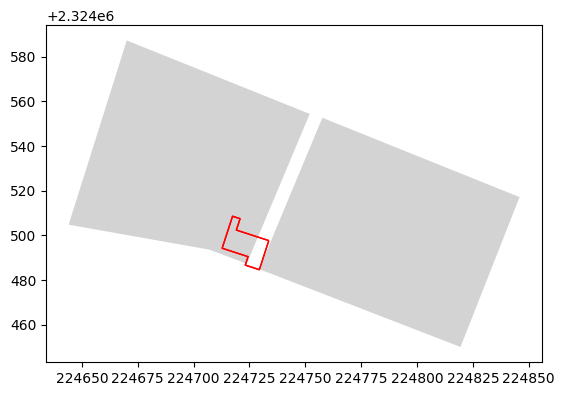

In [14]:
fig,ax=plt.subplots()

buildings_test.plot(ax=ax,
                    facecolor="none",
                    edgecolor='red',
                    zorder=1)
blocks_test.plot(ax=ax,
                 color='lightgrey',
                 zorder=0)

#### __REMOVE__

In [15]:
buildings_aoi_gdf_f = buildings_aoi_gdf.copy()
buildings_aoi_gdf_f.drop_duplicates('full_plus_code',inplace=True)

# Show
print(buildings_aoi_gdf_f.crs)
print(buildings_aoi_gdf_f.shape)
buildings_aoi_gdf_f.head(2)

EPSG:32616
(986036, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((200667.091 2327419.743, 200662.733 2...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((227049.324 2315155.737, 227049.241 2...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


## __Calculate mean pctbuilt_block by hex__

#### Load hexs with required output res

In [16]:
hex_schema = 'hexgrid'
hex_table = f'hexgrid_{output_res}_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Ensure projected_crs
if hex_gdf.crs != projected_crs:
    hex_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed hex_gdf crs to {projected_crs}.")

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

Changed hex_gdf crs to EPSG:32616.
EPSG:32616
(4043, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89450980dc3ffff,"POLYGON ((245178.033 2301955.637, 245313.767 2...",31002,Acanceh,Merida,urban
1,89450980993ffff,"POLYGON ((244697.664 2304088.133, 244833.41 23...",31002,Acanceh,Merida,urban


#### Split blocks using hexs (Overlay) and find block area by hex

In [17]:
# Rename CVEGEO before overlay
if 'CVEGEO' in blocks_aoi_gdf.columns:
    blocks_aoi_gdf.rename(columns={'CVEGEO':'cvegeo_mza'},inplace=True)

# Overlay blocks with hexs
# (This spatial intersection, creates split blocks with data from the original block and the hex it falls in)
blocks_hexs_overlay = gpd.overlay(df1=blocks_aoi_gdf[['cvegeo_mza','geometry']], 
                                  df2=hex_gdf[[f'hex_id_{output_res}','geometry']], 
                                  how="intersection")
# Calculate split area of each block
blocks_hexs_overlay['area_mza_split'] = blocks_hexs_overlay.geometry.area

# Group data by hex
blockarea_byhex = blocks_hexs_overlay.groupby(f'hex_id_{output_res}').agg({'area_mza_split':np.sum})

# Show
print(blockarea_byhex.shape)
blockarea_byhex.head(2)

(4012, 1)


,area_mza_split
hex_id_9,
89450916487ffff,39929.370337
89450916493ffff,45127.852693


#### Split buildings using hexs (Overlay) and find built area by hex

In [18]:
# Overlay buildings with hexs
# (This spatial intersection, creates split buildings with data from the original building and the hex it falls in)
buildings_hexs_overlay = gpd.overlay(df1=buildings_aoi_gdf_f[['full_plus_code','geometry']],
                                     df2=hex_gdf[[f'hex_id_{output_res}','geometry']],
                                     how="intersection")

# Dissolve buildings by hex
buildings_diss = buildings_hexs_overlay.dissolve(by=f'hex_id_{output_res}')
buildings_diss.reset_index(inplace=True)
# Calculate split built area of each building
buildings_diss['area_built_split'] = buildings_diss.geometry.area

# Group data by hex
builtarea_byhex = buildings_diss.groupby(f'hex_id_{output_res}').agg({'area_built_split':np.sum})

# Show
print(builtarea_byhex.shape)
builtarea_byhex.head(2)

(3835, 1)


,area_built_split
hex_id_9,
89450916487ffff,1265.052939
89450916493ffff,1372.721480


#### Merge block area by hex and built area by hex

In [19]:
if f'hex_id_{output_res}' not in blockarea_byhex.columns:
    blockarea_byhex.reset_index(inplace=True)
if f'hex_id_{output_res}' not in builtarea_byhex.columns:
    builtarea_byhex.reset_index(inplace=True)

areas_byhex = pd.merge(blockarea_byhex,builtarea_byhex,on=f'hex_id_{output_res}')

# Show
print(areas_byhex.shape)
areas_byhex.head(2)

(3833, 3)


,hex_id_9,area_mza_split,area_built_split
0,89450916487ffff,39929.370337,1265.052939
1,89450916493ffff,45127.852693,1372.721480


#### Calculate built percentage relative to blocks area by hex

In [20]:
areas_byhex['built_pct'] = (areas_byhex['area_built_split']/areas_byhex['area_mza_split'])*100

# Show
print(areas_byhex.shape)
areas_byhex.head(2)

(3833, 4)


,hex_id_9,area_mza_split,area_built_split,built_pct
0,89450916487ffff,39929.370337,1265.052939,3.168227
1,89450916493ffff,45127.852693,1372.721480,3.041850


Text(0.5, 1.0, 'Percentage of built area (Google Buildings) in Merida by block.')

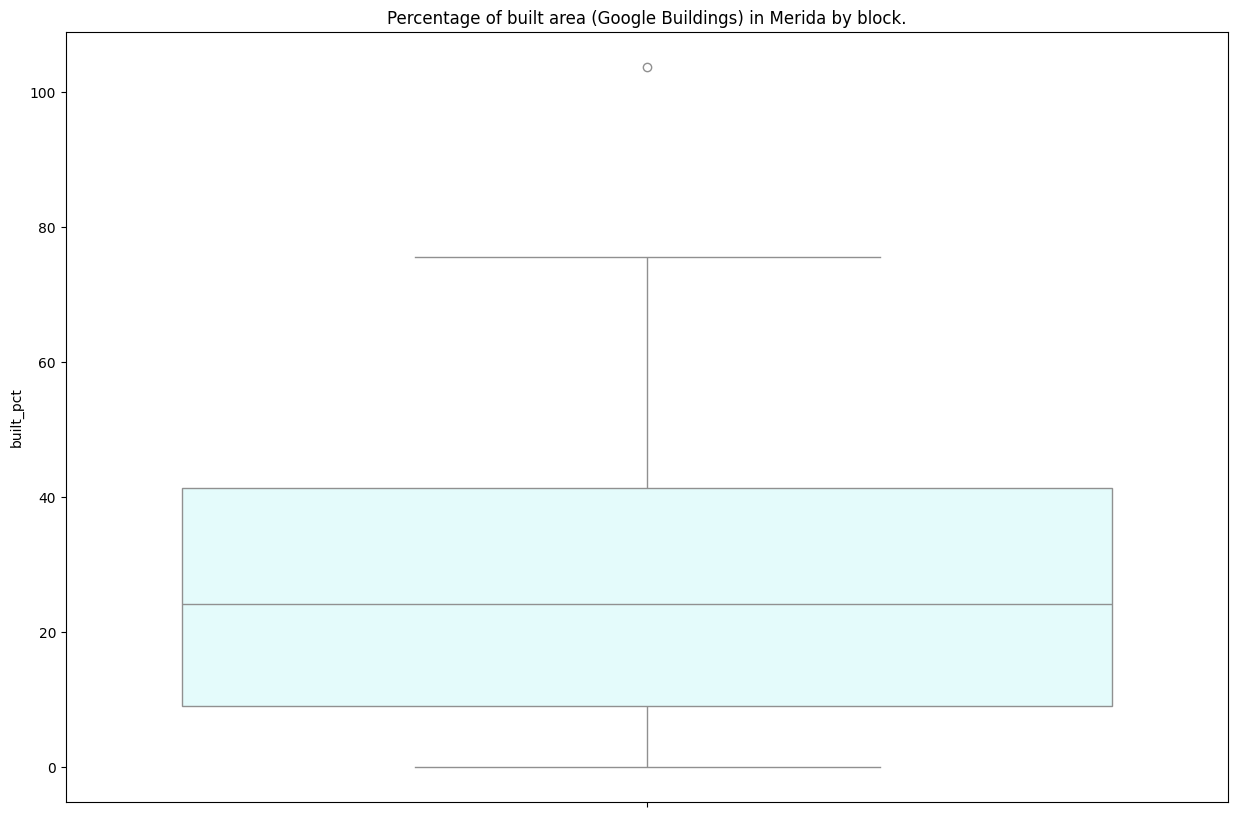

In [21]:
fig,ax=plt.subplots(figsize=(15,10))
sns.boxplot(areas_byhex.built_pct,
            color='lightcyan',
            zorder=0,
            ax=ax)
ax.set_title(f'Percentage of built area (Google Buildings) in {city} by block.')

#### Substitute all values above 100% with 100% built percentage

In [22]:
idx = areas_byhex.built_pct>=100
areas_byhex.loc[idx,'built_pct'] = 100

# Show
print(float(areas_byhex.built_pct.max()))
areas_byhex.head(2)

100.0


,hex_id_9,area_mza_split,area_built_split,built_pct
0,89450916487ffff,39929.370337,1265.052939,3.168227
1,89450916493ffff,45127.852693,1372.721480,3.041850


#### Retrieve geometry

In [23]:
# Merge with hex_gdf
hexs_built_df = pd.merge(areas_byhex,
                         hex_gdf[[f'hex_id_{output_res}','geometry']],
                         on=f'hex_id_{output_res}')
# Turn into GeoDataFrame
hexs_built_gdf = gpd.GeoDataFrame(hexs_built_df,
                                  crs=projected_crs,
                                  geometry='geometry')

# Show
print(hexs_built_gdf.crs)
print(hexs_built_gdf.shape)
hexs_built_gdf.head(2)

EPSG:32616
(3833, 5)


,hex_id_9,area_mza_split,area_built_split,built_pct,geometry
0,89450916487ffff,39929.370337,1265.052939,3.168227,"POLYGON ((252809.048 2323786.132, 252944.758 2..."
1,89450916493ffff,45127.852693,1372.721480,3.041850,"POLYGON ((252993.642 2323193.613, 253129.348 2..."


#### Show

<Axes: >

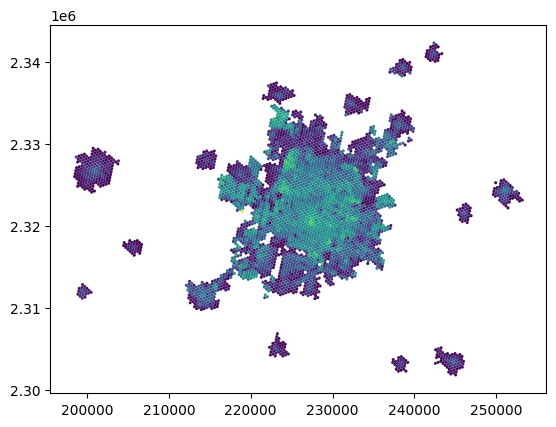

In [24]:
hexs_built_gdf.plot('built_pct')

In [25]:
if save_output:
    hexs_built_gdf.to_file(map_output_dir + f"/builtpctblock_{city}_hex{output_res}.gpkg")